# Astro 330 "Computational Astrophysics"

## Homework 5 : Computational Statistics


### Student: Dimitrios Tanoglidis 

### Problem 1) Fitting a linear model to data

#### Background

Observed disk galaxies exhibit a tight correlation between their luminosity, $L$, and rotation velocity of gas and stars, $V_{\rm rot}$ called the Tully-Fisher relation (Tully & Fisher 1977). This correlation can be well approximated by a power law $L\propto V_{\rm rot}^\eta$, where $\eta\approx 3-4$, depending on how luminosity and rotation velocity are measured.

A similar correlation exists between rotation velocity, $V_{\rm rot}$ and stellar mass, $M_\star$, or total mass of visible baryons, $M_{\rm b}$ (mass of stars + mass of atomic and molecular hydrogen). The latter (i.e., $M_{\rm b}-V_{\rm rot}$) is called the baryonic Tully-Fisher relation. In this exercise you will measure the intercept and slope of a linear model for $\log_{10} M_{\rm b}-\log_{10} V_{\rm rot}$ for the observed sample of galaxies with measured $M_\star$, $M_{\rm b}$, and $V_{\rm rot}$ assembled by Bradford et al. (2016). I've added a fits file with this data set as file bradford16_fig1.fits (downloaded from Jeremy Bradford's website, but renamed) in the data subdirectory. I include code snippet at the end, which shows how to read the file and how to extract required quantities and their uncertainties.

#### Exercise description

Assuming that uncertainties of $V_{\rm rot}$ and $M_{\rm b}$ are uncorrelated, use the likelihoods, as well as appropriate priors (choice is up to you), to derive constraints on the intercept, slope, and intrinsic scatter of the $M_{\rm b}-V_{\rm rot}$ relation for the following cases:

1. Using only one randonly chosen data point.

2. Using 2 randomly chosen data points.

3. Using all data points using different choices of models and likelihoods.

#### Required results and tests

1. Using the model that is symmetric relative to switch between these quantities as $x$ and $y$, described in the lecture notes (S 3.4.2) and in notebook ex15, derive and plot the marginalized posterior distributions for slope and intercept, $m$ and $c$ for the likelihood given by eq. 3.55 in the notes when using only 1 random data points, 2 random data points, and all data points. For the latter plot also posterior for the scatter in the perpendicular to the line direction, $s_\perp$. Compute 68\% and 95% credible regions for $m$, $c$, and $c_\perp$. (5 points)

2. Does the constraint on the scatter and its projection to $y$ direction $s=s_\perp\sqrt{1+m^2}$ make sense if you compare them to the residuals of $y-y_{\rm model}$? (5 points)

3. Derive constraints on $m$, $c$, $s_\perp$, using $V_{\rm rot}$ as $y$ and then $M_b$ as $y$. Compare the credible regions for the parameters in these two cases and check that they are similar. (5 points)

4. Repeat 3 for the assymetric likelihood given by eq 3.52 in the updated notes, and posterior in eq. 3.54. How do the slopes in the two fit cases compare for this likelihood? (5 points).

### Solution

First read and plot the data

In [682]:
import numpy as np

from code.setup import data_home_dir
from matplotlib import pyplot as plt
%matplotlib inline
from code.plot_utils import plot_pretty

plot_pretty()

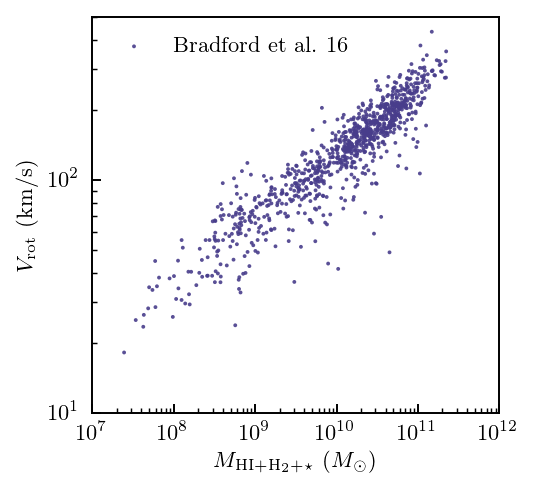

In [683]:
import pyfits

bf1 = pyfits.open('/Users/Dimitris/Desktop/CompAstro/data/bradford16_fig1.fits')[1].data
# if you want to see what's in the fits table, uncomment
#bf1h = pyfits.open(data_home_dir()+'bradford16_fig1.fits')[1].header
#print(bf1h)

# log10 of the baryon mass
mbbar = bf1['MBARYON']; 
# error of the baryon mass
embar = bf1['MBARYON_ERR']
# width of the 21 cm line = proxy for Vrot in km/s
w20b = bf1['VW20I']; 
# error of W20b
ew20b = bf1['VW20I_ERR']
#mbs = np.log10(mbs) + 9.0  # stellar mass is in 10^9 Msun in the file -> convert to Msun

plt.figure(figsize=(3.,3.))
plt.xscale('log'); plt.yscale('log')
plt.xlim([1.e7,1.e12]); plt.ylim([10.,500.])
plt.ylabel(r'$V_{\rm rot}\ \mathrm{(km/s)}$'); plt.xlabel(r'$M_{\rm HI+H_2+\star}\ {(M_\odot)}$')
plt.scatter(10.**mbbar,w20b,marker='.',c='darkslateblue',s=10.,alpha=0.9,edgecolor='none', label=r'$\mathrm{Bradford\ et\ al.\ 16}$')

plt.legend(frameon=False,loc='upper left', fontsize=9)
plt.show()

#### Fitting a model to data - Theory

Here I briefly summarize the theory and present the basic formulas we are going to use when trying to fit a model to data. 

The basic idea is very simple: we want to sample (perform a MCMC sampling) the posterior distribution of the parameters of our model (theory), given a set of data.

So, the problem is reduced to the following: find the posterior probability distribution function, $\pi(\vec{\theta}|\vec{d}_i,I)$.  What is usually easier is to find the likelihood of measurement $i$ of data $\vec{d}_i$, given a theory/model with parameters $\vec{\theta}$, $p_{m,i}(\vec{d}_i|\vec{\theta})$. Bayes theorem relates the two:

\begin{equation}
\pi(\vec{\theta}|\vec{d}_i,  I) = \frac{p_{m,i}(\vec{d}_i|\vec{\theta})p(\vec{\theta}|I)}{p(\vec{d}_i|I)} \qquad (1)
\end{equation}

In the above, $p(\vec{\theta}|I)$ is the prior probability of the parameters and $p(\vec{d}_i|I)$. The latter is not important in our analyisis here, since it is a normalization factor; the MCMC algorithm uses ratios of the probability distribution, so the normalization constant is irrelevant.

For a linear fit symmetric to $x$ and $y$ the likelihood of a measurement $x_i$, $y_i$ given the model parameters (linear fitting with an intrinsic scatter) $m$ (slope), $c$ (intercept), $s$ (scatter) is:

\begin{equation}
p_{m,i}(x_i,y_i|m,c,s) = \sqrt{\frac{(1+m^2)}{2\pi\sigma_{tot,i}^2}} \exp \left[-\frac{1}{2}\frac{(y_i - mx_i - c)^2}{\sigma_{tot,i}^2} \right] \qquad (2)
\end{equation}

For uncorrelated errors in $x$ and $y$ the total error $\sigma^2_{tot,i}$ is:

\begin{equation}
\sigma_{tot,i}^2 = s^2 + \sigma_{x_i}^2m^2 + \sigma_{y_i}^2, \qquad s^2 = s_\perp^2(1+m^2) \qquad (3)
\end{equation}

For a series of measurements then, the posterior for the parameters $m,c,s$ is:

\begin{equation}
\pi(m,c,s|\vec{x},\vec{y},I) = \frac{1}{Z} p(m,c,s|I) \prod_{i} \sqrt{\frac{(1+m^2)}{2\pi\sigma_{tot,i}^2}} \exp \left[-\frac{1}{2}\frac{(y_i - mx_i - c)^2}{\sigma_{tot,i}^2} \right] \qquad (4)
\end{equation}

According to the discussion in the notes, I take for prior in $m$:
\begin{equation} 
p(m) \propto \frac{dm}{1 + m^2} 
\end{equation}
and for $c$:
\begin{equation}
p(c) \propto \frac{dc}{\sqrt{1+m^2}}
\end{equation}
Because of the similarity of $c$ and $s$ in symmetry issues, I also tace for prior in $s$: 
\begin{equation}
p(s) \propto \frac{ds}{\sqrt{1+m^2}}
\end{equation}

So the total prior is:

\begin{equation}
p(m,c,s|I) = \frac{dm dc ds}{(1+m^2)^2} \qquad (5)
\end{equation} 


#### Fitting Using one randomly chosen point

Let's start by selecting randomly one point as our data point and fit using the above formulae.

In [684]:
# First let's chose one random data point from the above given

import random as rnd

d_point = rnd.choice(bf1)

# log10 of the baryon mass
m_bar = d_point['MBARYON']; 
# error of the baryon mass
em_bar = d_point['MBARYON_ERR']
# width of the 21 cm line = proxy for Vrot in km/s
w_20b = d_point['VW20I']; 
# error of W20b
ew_20b = d_point['VW20I_ERR']



The Fitting will be around the mean linear relation. We have to be careful with units.

The baryonic Tully-Fisher relation can be written in our case:
\begin{equation}
\frac{V_{rot}}{km/s} = a\frac{M_\odot}{km/s}\left(\frac{M}{M_\odot}\right)^m \Rightarrow \log\left( \frac{V_{rot}}{km/s}  \right) = \log\left(a\frac{M_\odot}{km/s}\right) + m\log\left( \frac{M}{M_\odot}\right)
\end{equation}

Identifying $c = \log\left(a\frac{M_\odot}{km/s}\right)$, the above can be written as:

\begin{equation}
\log\left( \frac{M}{M_\odot}  \right) = c + m\log\left(\frac{V}{km/s} \right) \qquad (6)
\end{equation}

This is the formula we are going to use. Note that here we have $V_{rot}$ and its error in $km/s$, ot the logarithm. We have to take the logarithms.

Propagating the errors, the error of the log of the speed will be:

\begin{equation}
\sigma_{\log V} = \frac{1}{V \ln10 }\sigma_V \qquad(7)
\end{equation}


In [685]:
#y is the log of rot speed and its error as given by (7)
y_dat = np.log10(w_20b)
err_y = ew_20b/(w_20b*np.log(10.0))
x_dat = m_bar
err_x = em_bar

data = [x_dat, err_x, y_dat, err_y]

In [686]:
def log_prior(theta):
    """ 
    Returns the log of the prior - equation (5)
    
    """
    m = theta[0]; c = theta[1]; s = theta[2]
    
    if  (abs(m)<5.0 and abs(c)<5.0 and abs(s)<2.0): 
        return -2.0*np.log(1.0 + m**2.0)
    else:
        return  -np.inf  # log(0)
    
    
def log_likelihood_1d(theta, data=data):
    """
    Returns the log of the likelihood - see eq. (2)
    For one data point
    """
    m = theta[0]; c = theta[1]; s = theta[2]
    x, e_x, y, e_y = data
    
    #the sigma total square - see eq. (3)
    sig_sq = s**2.0 + (m*e_x)**2.0 + (e_y)**2.0
    log_sqrt = 0.5*(np.log(1.0 + m**2.0) - np.log(2.0*np.pi*sig_sq))
    log_exp = 0.5*((y - m*x - c)**2.0)/sig_sq
 
    return log_sqrt - log_exp
    

def log_posterior_1d(theta, data=data):
    """
    Returns the posterior distribution - eq. (4)
    
    """
    return log_prior(theta) + log_likelihood_1d(theta, data)


In [687]:
import emcee

def compute_mcmc_1p(ndim, data=data,
                   log_posterior_1d=log_posterior_1d,
                   nwalkers=50, nburn=1000, nsteps=2000):
      
    rng = np.random.RandomState(0)
    starting_guesses = rng.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_1d, args=[data])
    sampler.run_mcmc(starting_guesses, nsteps)
    trace = sampler.chain[:, nburn:, :].reshape(-1, ndim)
    return trace

In [688]:
trace_1p = compute_mcmc_1p(3)

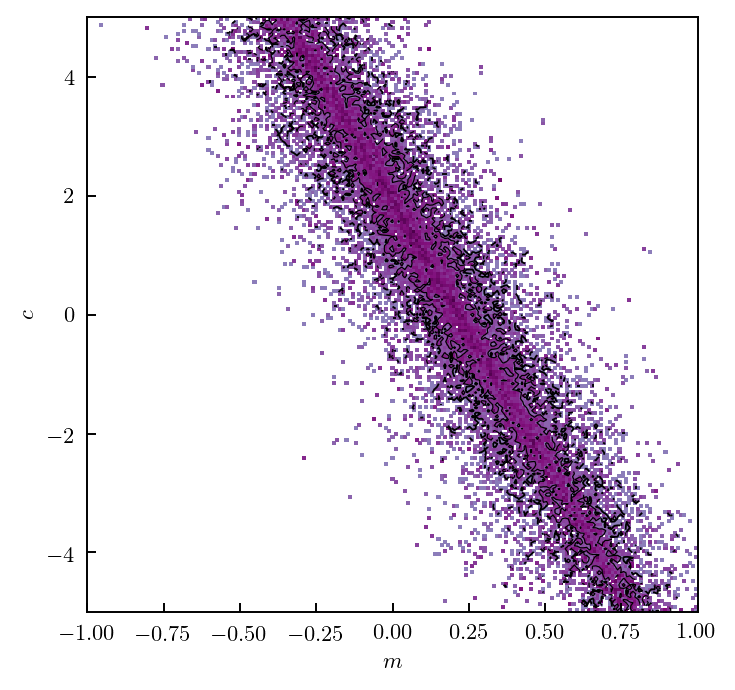

In [689]:
from code.plot_utils import plot_2d_dist

clevs = (0.683, 0.955, 0.997)# Standard contour levels 

plot_2d_dist(trace_1p[:,0], trace_1p[:,1], xlim=[-1,1], ylim =[-5,5], nxbins=200, nybins=200, 
             clevs=clevs[::-1], xlabel='$m$', ylabel='$c$')

### Two Data Points

In [690]:
d_point_1 = rnd.choice(bf1)
d_point_2 = rnd.choice(bf1)


#Masses and speeds for the first particle

# log10 of the baryon mass
m_bar_1 = d_point_1['MBARYON']; 
# error of the baryon mass
em_bar_1 = d_point_1['MBARYON_ERR']
# width of the 21 cm line = proxy for Vrot in km/s
w_20b_1 = d_point_1['VW20I']; 
# error of W20b
ew_20b_1 = d_point_1['VW20I_ERR']

# Masses and speeds for the second particle

# log10 of the baryon mass
m_bar_2 = d_point_2['MBARYON']; 
# error of the baryon mass
em_bar_2 = d_point_2['MBARYON_ERR']
# width of the 21 cm line = proxy for Vrot in km/s
w_20b_2 = d_point_2['VW20I']; 
# error of W20b
ew_20b_2 = d_point_2['VW20I_ERR']

y_dat_1 = np.log10(w_20b_1)
err_y_1 = ew_20b_1/(w_20b_1*np.log(10.0))
x_dat_1 = m_bar_1
err_x_1 = em_bar_1

y_dat_2 = np.log10(w_20b_2)
err_y_2 = ew_20b_2/(w_20b_2*np.log(10.0))
x_dat_2 = m_bar_2
err_x_2 = em_bar_2


data_n = [[x_dat_1, err_x_1, y_dat_1, err_y_1],[x_dat_2, err_x_2, y_dat_2, err_y_2]]


In [691]:
def log_posterior_2d(theta, data=data):
    """
    Returns the posterior distribution - eq. (4)
    
    """
    return log_prior(theta) + log_likelihood_1d(theta, data[0]) + log_likelihood_1d(theta, data[1])

In [692]:
def compute_mcmc_2p(ndim, data_n=data_n,
                   log_posterior_2d=log_posterior_2d,
                   nwalkers=50, nburn=1000, nsteps=2000):
      
    rng = np.random.RandomState(0)
    starting_guesses = rng.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_2d, args=[data_n])
    sampler.run_mcmc(starting_guesses, nsteps)
    trace = sampler.chain[:, nburn:, :].reshape(-1, ndim)
    return trace

In [693]:
trace_2p = compute_mcmc_2p(3)

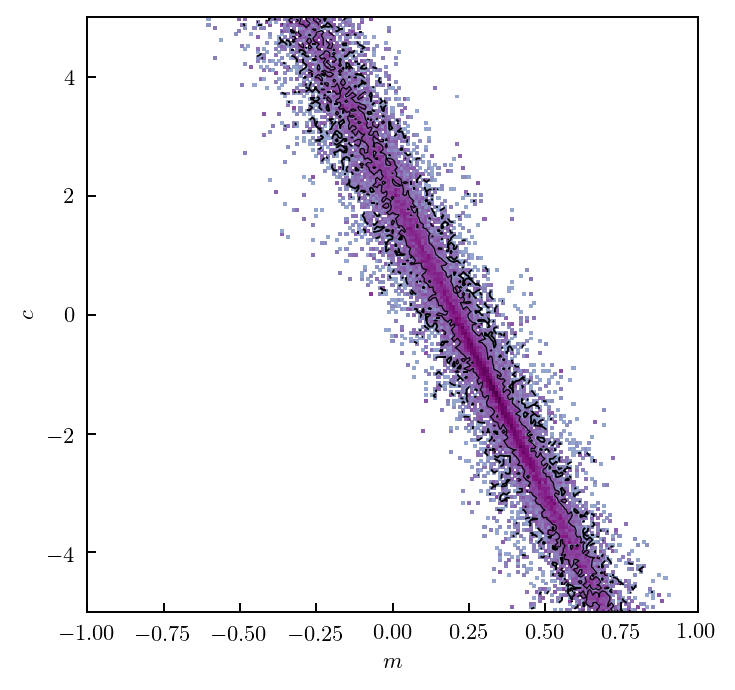

In [694]:
plot_2d_dist(trace_2p[:,0], trace_2p[:,1], xlim=[-1,1], ylim =[-5,5], nxbins=200, nybins=200, 
             clevs=clevs[::-1], xlabel='$m$', ylabel='$c$')

### Using all data points

In [695]:
#y is the log of rot speed and its error as given by (7)
y = np.log10(w20b)
e_y = ew20b/(w20b*np.log(10.0))
x = mbbar
e_x = embar

n = np.size(y)

data_all = []

for i in range (0,n):
    dat_i = [x[i],e_x[i],y[i],e_y[i]]
    data_all.append(dat_i)   

In [696]:
# Posterior distribution when all data points are used

def log_posterior_all(theta, data=data):
    """
    Returns the posterior distribution - eq. (4)
    
    """
    log_posterior = log_prior(theta) 

    for i in range(0,n):
        log_posterior += log_likelihood_1d(theta, data[i])
        
    return log_posterior

In [697]:
def compute_mcmc_all(ndim, data_all=data_all,
                   log_posterior_all=log_posterior_all,
                   nwalkers=50, nburn=1000, nsteps=2000):
      
    rng = np.random.RandomState(0)
    starting_guesses = rng.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_all, args=[data_all])
    sampler.run_mcmc(starting_guesses, nsteps)
    trace = sampler.chain[:, nburn:, :].reshape(-1, ndim)
    return trace

In [698]:
trace_all = compute_mcmc_all(3)

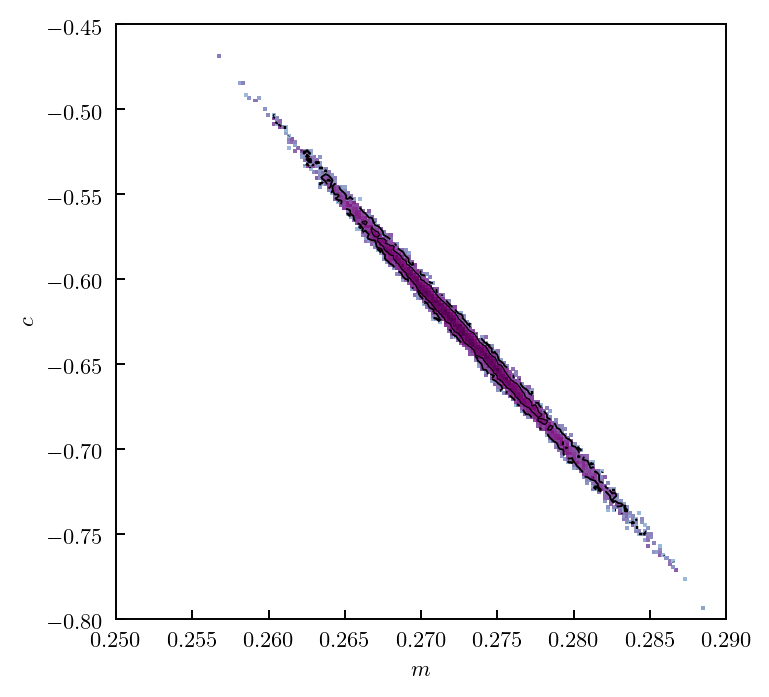

In [721]:

plot_2d_dist(trace_all[:,0], trace_all[:,1], xlim=[0.25,0.29], ylim =[-0.8,-0.45], nxbins=200, nybins=200, 
             clevs=clevs[::-1], xlabel='$m$', ylabel='$c$')

### Answering the questions

Now that our samplers run for the three cases (where we used 1, 2 and all data points), we can proceed more carefully and answer the questions.

#### Question 1

Above we have plotted the joint posterior distributions of the slope $m$ and intercept $c$ as well as the standard confidence intervals. 

Here let's also plot the joint postirior distribution of the slope $m$ and intrinsic scatter $s$ for the last case, where we have used all points.

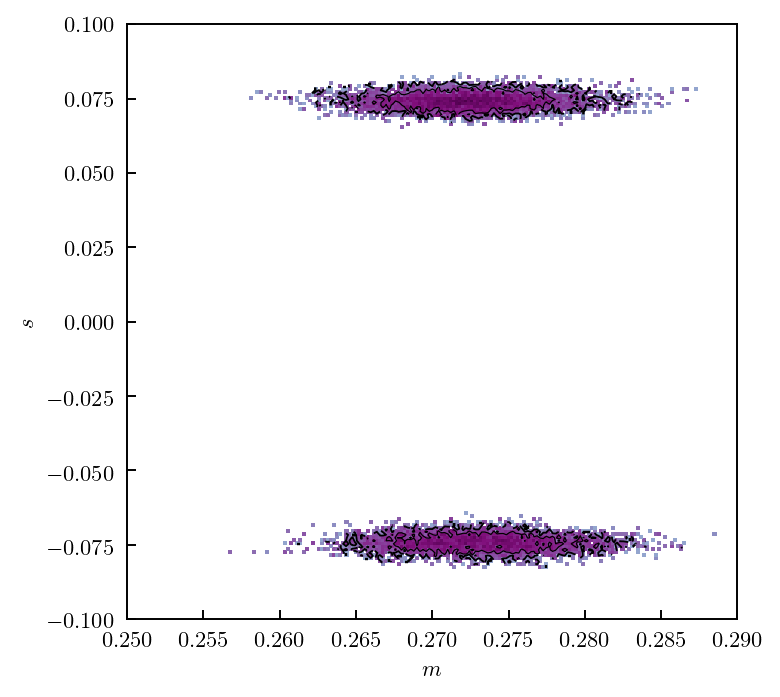

In [723]:
plot_2d_dist(trace_all[:,0], trace_all[:,2], xlim=[0.25,0.29], ylim =[-0.1,0.1], nxbins=200, nybins=200, 
             clevs=clevs[::-1], xlabel='$m$', ylabel='$s$')

Let's also plot histograms for $m$, $c$ for all cases and $s$ for the last case.

##### 1 data point

In [724]:
from scipy import stats
import scipy as sp

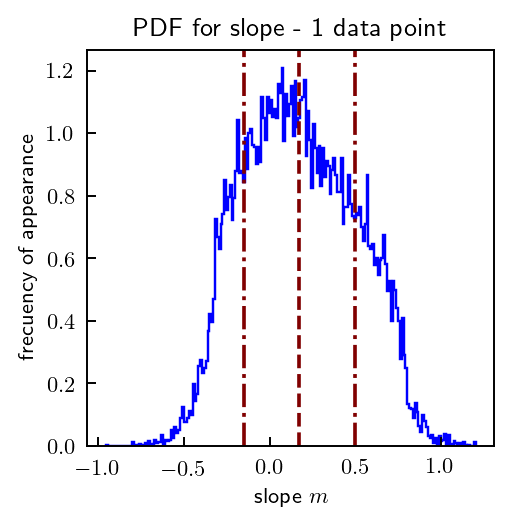

(0.1719012858322308, -0.15193314961545984, 0.49573572127992144)


In [725]:
n, min_max, mean, var, skew, kurt = stats.describe(trace_1p[:,0])

m_1p_mean = mean
ll = mean - np.sqrt(var)
ul = mean + np.sqrt(var)


plt.figure(figsize=(3.0,3.0))

plt.hist(trace_1p[:,0], bins=200, histtype='step', normed=1, color='blue')
plt.axvline(m_1p_mean, c = 'maroon', ls='--')
plt.axvline(ll, c= 'maroon', ls='-.')
plt.axvline(ul, c ='maroon', ls='-.')
plt.xlabel('slope $m$');plt.ylabel('frecuency of appearance')
plt.title('PDF for slope - 1 data point')


plt.show()

print(m_1p_mean, ll, ul)

The vertical line indicates the position of the mean, which is:

In [726]:
print(m_1p_mean)

0.171901285832


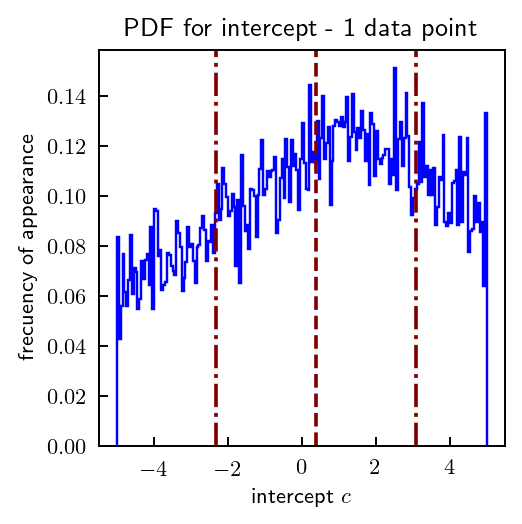

In [727]:
n, min_max, mean, var, skew, kurt = stats.describe(trace_1p[:,1])

c_1p_mean = mean
ll = mean - np.sqrt(var)
ul = mean + np.sqrt(var)



plt.figure(figsize=(3.0,3.0))

plt.hist(trace_1p[:,1], bins=200, histtype='step', normed=1, color='blue')
plt.axvline(c_1p_mean, c = 'maroon', ls='--')
plt.axvline(ll, c= 'maroon', ls='-.')
plt.axvline(ul, c ='maroon', ls='-.')
plt.xlabel('intercept $c$');plt.ylabel('frecuency of appearance')
plt.title('PDF for intercept - 1 data point')


plt.show()

The vertical line indicates the position of the mean, which is:

In [728]:
print(c_1p_mean)

0.369802126327


##### 2 data points

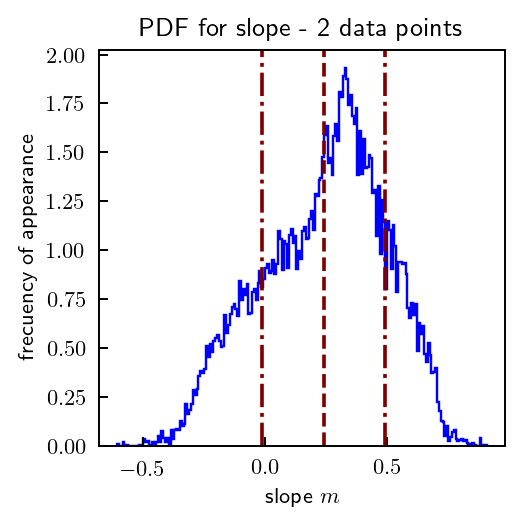

In [729]:
n, min_max, mean, var, skew, kurt = stats.describe(trace_2p[:,0])

m_2p_mean = mean
ll = mean - np.sqrt(var)
ul = mean + np.sqrt(var) 

plt.figure(figsize=(3.0,3.0))

plt.hist(trace_2p[:,0], bins=200, histtype='step', normed=1, color='blue')
plt.axvline(m_2p_mean, c = 'maroon', ls='--')
plt.axvline(ll, c= 'maroon', ls='-.')
plt.axvline(ul, c ='maroon', ls='-.')
plt.xlabel('slope $m$');plt.ylabel('frecuency of appearance')
plt.title('PDF for slope - 2 data points')


plt.show()

The vertical line indicates the position of the mean, which is:

In [730]:
print(m_2p_mean)

0.239032408546


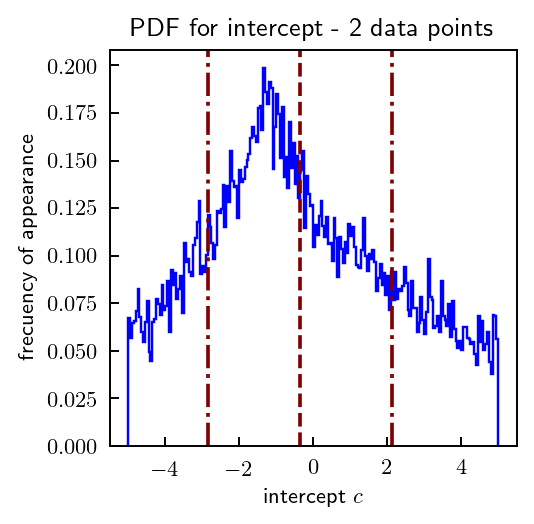

In [731]:
n, min_max, mean, var, skew, kurt = stats.describe(trace_2p[:,1])

c_2p_mean = mean
ll = mean - np.sqrt(var)
ul = mean + np.sqrt(var)

plt.figure(figsize=(3.0,3.0))

plt.hist(trace_2p[:,1], bins=200, histtype='step', normed=1, color='blue')
plt.axvline(c_2p_mean, c = 'maroon', ls='--')
plt.axvline(ll, c= 'maroon', ls='-.')
plt.axvline(ul, c ='maroon', ls='-.')
plt.xlabel('intercept $c$');plt.ylabel('frecuency of appearance')
plt.title('PDF for intercept - 2 data points')


plt.show()

#### All data points

Finally we consider the 1d posterior distributions  of $m$, $c$ and $s$ when we use all data points. We will use them later to answer the second question.

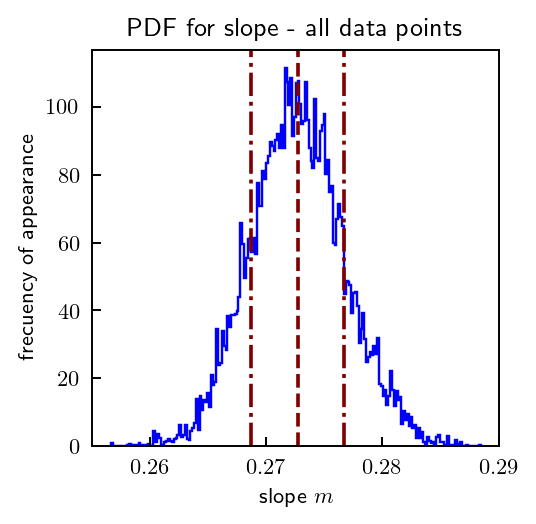

In [732]:
n, min_max, mean, var, skew, kurt = stats.describe(trace_all[:,0])

m_all_mean = mean
ll = mean - np.sqrt(var)
ul = mean + np.sqrt(var)

plt.figure(figsize=(3.0,3.0))

plt.hist(trace_all[:,0], bins=200, histtype='step', normed=1, color='blue')
plt.axvline(m_all_mean, c = 'maroon', ls='--')
plt.axvline(ll, c= 'maroon', ls='-.')
plt.axvline(ul, c ='maroon', ls='-.')
plt.xlabel('slope $m$');plt.ylabel('frecuency of appearance')
plt.title('PDF for slope - all data points')


plt.show()

Mean of the slope is:

In [733]:
print(m_all_mean)

0.272714234658


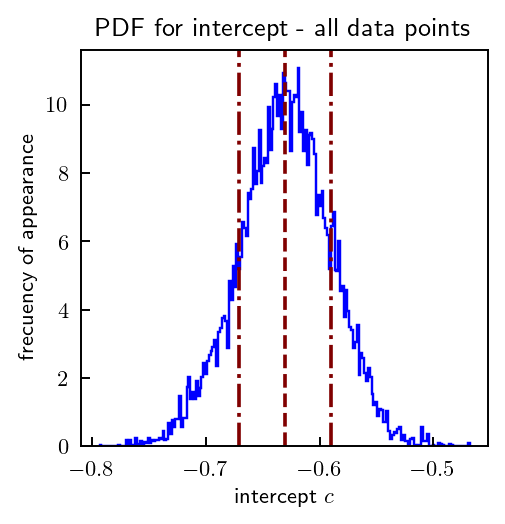

In [734]:
n, min_max, mean, var, skew, kurt = stats.describe(trace_all[:,1])

c_all_mean = mean
ll = mean - np.sqrt(var)
ul = mean + np.sqrt(var)

plt.figure(figsize=(3.0,3.0))

plt.hist(trace_all[:,1], bins=200, histtype='step', normed=1, color='blue')
plt.axvline(c_all_mean, c = 'maroon', ls='--')
plt.axvline(ll, c= 'maroon', ls='-.')
plt.axvline(ul, c ='maroon', ls='-.')
plt.xlabel('intercept $c$');plt.ylabel('frecuency of appearance')
plt.title('PDF for intercept - all data points')


plt.show()

Mean of the intercept is:

In [735]:
print(c_all_mean)

-0.630448202971


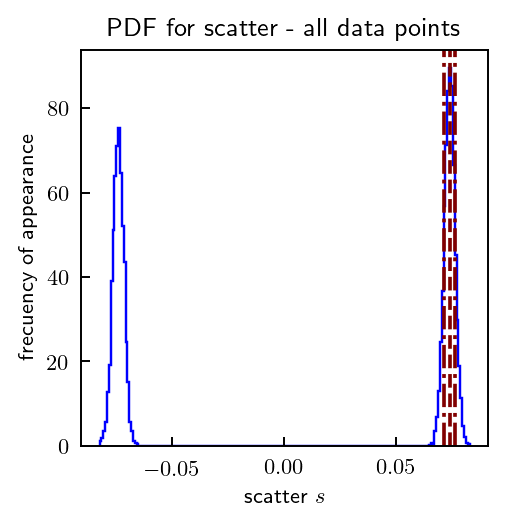

In [736]:
n, min_max, mean, var, skew, kurt = stats.describe(abs(trace_all[:,2]))

s_all_mean = mean
ll = mean - np.sqrt(var)
ul = mean + np.sqrt(var)

plt.figure(figsize=(3.0,3.0))

plt.hist(trace_all[:,2], bins=200, histtype='step', normed=1, color='blue')
plt.axvline(s_all_mean, c = 'maroon', ls='--')
plt.axvline(ll, c= 'maroon', ls='-.')
plt.axvline(ul, c ='maroon', ls='-.')
plt.xlabel('scatter $s$');plt.ylabel('frecuency of appearance')
plt.title('PDF for scatter - all data points')


plt.show()

Mean of the scatter is:

In [737]:
print(s_all_mean)


0.0741440797846


#### Question 2

Here we will check that our model with the intrinsic scatter in the $y$ direction describes well the data. 

For that reason we plot the best linear fit with the slope $m$ and intercept $c$, as well linear fits that take into account the intrinsic scatter in the $y$ direction, i.e. they have intercepts $c+s$ and $c-s$.

In [742]:
x_like = np.linspace(7.0,12.0, 100)
x = 10.0**x_like

y = 10**(c_all_mean)*(x**m_all_mean)
y_up = 10**(c_all_mean+s_all_mean)*(x**m_all_mean)
y_dn = 10**(c_all_mean-s_all_mean)*(x**m_all_mean)

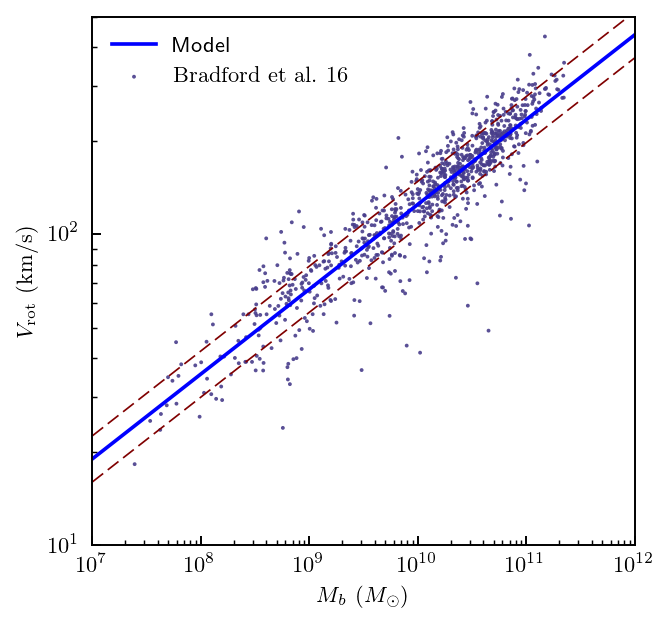

In [747]:
plt.figure(figsize=(4.,4.))
plt.xscale('log'); plt.yscale('log')
plt.xlim([1.e7,1.e12]); plt.ylim([10.,500.])
plt.plot(x, y, c ='blue', label=r'Model')
plt.plot(x, y_up, c ='maroon', ls='--', linewidth=0.7)
plt.plot(x, y_dn, c ='maroon', ls='--', linewidth = 0.7)
plt.ylabel(r'$V_{\rm rot}\ \mathrm{(km/s)}$'); plt.xlabel(r'$M_b\ {(M_\odot)}$')
plt.scatter(10.**mbbar,w20b,marker='.',c='darkslateblue',s=10.,alpha=0.9,edgecolor='none', label=r'$\mathrm{Bradford\ et\ al.\ 16}$')

plt.legend(frameon=False,loc='upper left', fontsize=9)
plt.show()

From the above diagram we can see that:

$\bullet$ First, that the model fits well the data.

$\bullet$ The constraints on scatter make sence; most points lie inside the range that is defined by linear fits with the same slope $m$, but intersepts $c+s$ and $c-s$ (the intercept of the model $\pm$ the intrinsic scatter).

#### Question 3

In [748]:
#y is the log of rot speed and its error as given by (7)
x = np.log10(w20b)
e_x = ew20b/(w20b*np.log(10.0))
y = mbbar
e_y = embar

n = np.size(y)

data_all_new = []

for i in range (0,n):
    dat_i = [x[i],e_x[i],y[i],e_y[i]]
    data_all_new.append(dat_i) 
    
    
def compute_mcmc_all_new(ndim, data_all_new=data_all_new,
                   log_posterior_all=log_posterior_all,
                   nwalkers=50, nburn=1000, nsteps=2000):
      
    rng = np.random.RandomState(0)
    starting_guesses = rng.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_all, args=[data_all_new])
    sampler.run_mcmc(starting_guesses, nsteps)
    trace = sampler.chain[:, nburn:, :].reshape(-1, ndim)
    return trace

In [751]:
trace_all_new = compute_mcmc_all_new(3)

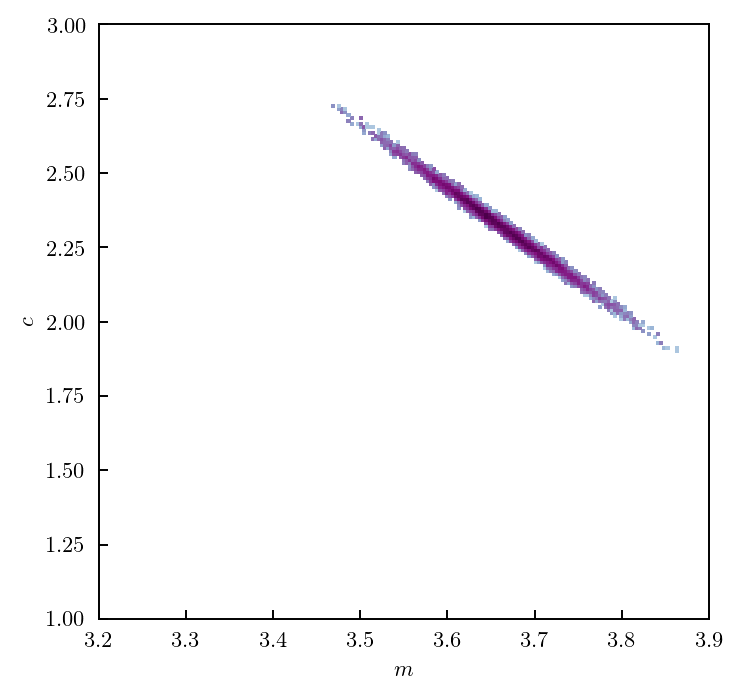

In [768]:

plot_2d_dist(trace_all_new[:,0], trace_all_new[:,1], xlim=[3.2,3.9], ylim =[1,3], nxbins=200, nybins=200, 
             clevs=None, xlabel='$m$', ylabel='$c$')

###  Problem 3. Model fitting and non-linear parameter estimation using MCMC: cosmological constraints from the Baryonic Acoustic Oscillations. (30 points)
Background.
In this exertcise you will use the Baryonic Acoustic Oscillation (BAO) feature in the 2-point correlation function of the Luminous Red Galaxies (LRGs) recently measured in DR11 of the BOSS survey by Anderson et al. 2014 (hereafter A14). You will use the MCMC sampler developed in the HW4 and parallelized above, as well as the experience in numerically integrating power spectrum gained in HW2, to compute theoretical $\Lambda$CDM prediction for $\xi(r)$ and to derive useful constraint on the mean density of matter in the universe, un units of the critical density: $\Omega_{\rm m,0}=\rho_{\rm m}(z=0)/\rho_{\rm crit}$, where critical density is $\rho_{\rm crit}=3H_0^2/(8\pi G)$ is the density of matter that would be required to make the universe flat without additional contribution from vacuum energy.
More precisely, BAO using measurements of the quality of DR11, can constrain location of the peak, but not its shape. Location depends on the so-called dilation parameter $\alpha$ defined as
$$\alpha=\frac{D_V(z)}{D_{V,\rm fid}(z)}\,\frac{r_{d,\rm fid}}{r_{\rm d}},$$
where $r_d$ is the comoving size of the sound horizon (distance acoustic waves could travel during the age of the universe) at the "drag epoch" and $D_V(z)$ is the following function of the Hubble expansion rate $H(z)$ and angular diameter distance, $d_A(z)$:
$$ D_V(z)=\left[cz(1+z)^2 d_A^2(z)H^{-1}(z)\right]^{1/3}.$$
$D_{V,\rm fid}(z)$ is this function computed for some fiducial cosmological parameters that are expected to be close to the true values (see below or S 1 of A14).  $d_A(z)$ and $H(z)$ depend on $\Omega_{\rm m,0}$, $\Omega_{\Lambda}$ and $H_0$ and constaint on $\alpha$ is thus a constraint on a combination of these parameters.
Expressions for the sound horizon $r_d$ can be found in eq. 4 in Eisenstein & Hu 1999.:
$$
r_d(z_d)=\frac{44.5\,\ln[9.83/(\Omega_{\rm m,0}h^2)]}{\sqrt{1+10(\Omega_{\rm b,0}h^2)^{3/4}}}\ \ \mathrm{Mpc}.
$$
Note that the units of $r_d$ in the above equation are in Mpc, not in $h^{-1}$ Mpc.
Exercise description
Part 1 (10 points)
Choose the same fiducial cosmology as in A14 (see their section 1): $\Omega_{\rm m0}=0.274$, $\Omega_{\Lambda}=1-\Omega_{\rm m0}=0.726$, $h=0.7$, $\Omega_b h^2=0.0224$, $n_s=0.95$, $\sigma_8=0.8$.
Compute the model correlation function using eqs 25 and 26 in Anderson et al. with parameters above. To compute the correlation function, we need to evaluate integral numerically, which is something that you did in HW2. For $P(k)$ we can use Eisenstein \& Hu (1998) approximation for the power spectrum, given by colossus.
Construct the full model correlation function using eq. 27 in A14 using free bias parameter $B^2_{\xi}$ and additive polynomial. These parametrize the unknown bias of the LRG galaxies and effects of the redshift-space distortions and systematic errors in the binned measured correlation function. The correlation function is shifted left and right in $r$ via the ``dilation'' parameter $\alpha$ defined as described above (see S 4 in A14):
Use your MCMC sampler to sample the posterior pdf of the model parameter $\alpha$ and nuisance parameters $B^2_{\xi}$, $a_1$, $a_2$, $a_3$ defined by the pdf: $$
\pi(\mathbf{p}\vert\mathbf{d})\propto \exp\left[-\frac{1}{2}(\mathbf{m}-\mathbf{d})^{\rm T}\mathbf{C}^{-1}(\mathbf{m}-\mathbf{d})\right]p(\mathbf{m}|I),
$$ where $\mathbf{d}=\{\xi(s_i)\}$ is the measured correlation function vector, $\mathbf{m}=\{\xi_{\rm fit}(s_i)\}$ is the corresponding vector of the model corr. function that depends on parameters $\mathbf{p}=\{\alpha,B_{\xi}^2,a_1,a_2,a_3\}$, $\mathbf{C}$ is the covariance matrix of $\{\xi(s)\}$ measurements (supplied along with  $\{\xi(s_i)\}$). $p(\mathbf{m}|I)$ is the prior pdf for model parameters $\mathbf{m}$. You should choose prior distribution that you think is reasonable/appropriate.
Part 2 (20 points)
Repeat the fitting of observed correlation function in the task 1, but instead of using template $\xi(r)$ and dilation parameter $\alpha$, compute model correlation function for varying $\Omega_{\rm m0}$ and $\Omega_{\Lambda}=1-\Omega_{\rm m,0}$ (i.e., assuming flat geometry of the universe, $\Omega_{\rm m,0}+\Omega_\Lambda=1$), while keeping the nuisance parameters fixed to the best fit values from calculation above and keeping other cosmological parameters fixed. Use colossus and the EH98 approximation to $P(k)$ to compute the model $\xi_{\rm fit}(s)$ for each of the sampled cosmological parameter combinations, as was done in the extra-credit problem of HW2.
Hints and useful info:
If you read the Anderson et al. (2014) paper, you will see that to get their cosmological constraints they do not fit the observed LRG correlation function with a fully self-consistent model $\xi(r)$. Instead, they use model $\xi(r)$ computed for a fiducial cosmology (assumed to be close to the actual cosmology) and simply use it as a template to to measure position of the BAO peak in $r$. At the same time, the information about the shape of $\xi(r)$ measured in observations is essentially ignored, in large part because it is not measured very accurately at these large scales. Thus, $\xi(r)$ can be computed only once.
Note that you can easily compute inverse of the covariance matrix (which you will need for the likelihood) using numpy's np.linalg.inv
You may also think about using 1d and/or 2D splines of functions for faster computation.
Required tests and results
Part 1
Plot posterior distribution of $\alpha$ from your chains as a histogram and measure its mean value and $68\%$ and $95\% $ confidence limits.
Plot posterior distributions of pairs other nuisance parameters in the form of contour plots. You may find corner package by Dan Foreman-Mackey for making "corner plots" of this kind useful.
Part 2
Plot posterior distribution of $\Omega_{\rm m,0}$ from your chains as a histogram.
Convert constraints on $\Omega_{\rm m0}$ from your chains into constraint on $\alpha$ and compare it to the result in Part 1 using formula for $\alpha$ above. Do you get consistent results?